In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import imageio
import os
import multiprocess as mp
from scipy.stats import maxwell

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
np.random.seed(42)

In [3]:
t_max = 100
dt = .002
N = 64

In [4]:
def init(N, L, lattice_constant):
    
    positions = list(np.arange(-L/2., L/2., lattice_constant))
    r0 = np.array(np.meshgrid(positions, positions, positions)).T.reshape(-1,3)
    p0 = maxwell.rvs(loc=0, scale=1.5, size=(N,3))
    
    return r0, p0

In [5]:
def LJ_force(r, sigma=1, periodic=False):

    bond_force = np.zeros(r.shape)

    for i, r_i in enumerate(r):
        d = r[np.arange(len(r)) != i] - r[i]
        f = 24 * (2*(sigma/np.linalg.norm(d, axis=1))**12 - (sigma/np.linalg.norm(d, axis=1))**6) / np.linalg.norm(d, axis=1)**2
        bond_force[i] = (np.expand_dims(f, axis=0).T * d).sum(axis=0)
        
        #f = 24 * (2*(sigma/np.linalg.norm(r_i, axis=0))**12 - (sigma/np.linalg.norm(r_i, axis=0))**6) / np.linalg.norm(r_i, axis=0)**2
        #bond_force[i] = (np.expand_dims(f, axis=0).T * r_i).sum(axis=0)
        
        bond_force[i] /= np.linalg.norm(bond_force[i])

    return bond_force

In [6]:
r0, p0 = init(N=64, L=6., lattice_constant=1.5)

In [7]:
R, P, t = a.velocity_verlet_Ndim(r0, p0, t_max, dt, LJ_force, 
                                periodic={'PBC': True, 'box_size': 6., 'force': True})

100%|██████████| 49999/49999 [05:44<00:00, 145.02it/s]


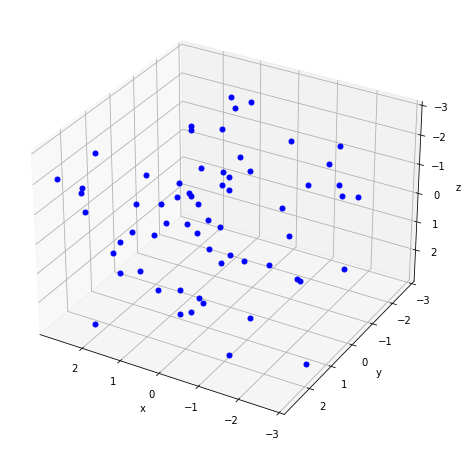

In [11]:
xlim = (R[:,:,0].max(), R[:,:,0].min())
ylim = (R[:,:,1].max(), R[:,:,1].min())
zlim = (R[:,:,2].max(), R[:,:,2].min())
files = []
for i in range(len(t)):
    
    if i%876==0:
        plt.clf()
        fig = plt.figure(figsize=(12,8));
        ax = fig.add_subplot(111, projection='3d')
        for part_i, part in enumerate(R[i]):
            ax.plot(part[0], part[1], part[2], color='blue', linestyle='', marker='o', markersize=5)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        
        filename = f'./figures/frame_{int(i/876)}.png'
        plt.savefig(filename)
        files.append(filename)
        
        plt.draw()
        IPython.display.clear_output(wait=True)
        IPython.display.display(fig)
    plt.close()
IPython.display.clear_output(wait=True)

In [12]:
with imageio.get_writer('./figures/3d_trajectory.gif', mode='I', fps=5) as writer:
    for file in files:
        image = imageio.imread(file)
        os.remove(file)
        writer.append_data(image)

In [36]:
r0, p0 = init(N=64, L=6., lattice_constant=1.5)

R_2dt, P_2dt, t_2dt = a.velocity_verlet_Ndim(r0, p0, t_max, 2*dt, LJ_force, 
                                             periodic={'PBC': True, 'box_size': 6., 'force': True})

100%|██████████| 24999/24999 [02:52<00:00, 145.08it/s]


In [37]:
def calc_energy(r, p, sigma=1):
    
    V = 0
    for i, r_i in enumerate(r):
        d = np.linalg.norm(r[np.arange(len(r)) != i] - r[i])
        #V_i = (4*((sigma/np.linalg.norm(d, axis=1))**12 - (sigma/np.linalg.norm(d, axis=1))**6)).sum()
        V_i = 4*((sigma/d)**12 - (sigma/d)**6)
        V += V_i
    
    T = (np.linalg.norm(p, axis=1)**2 / 2.).sum()
    
    return V + T

In [38]:
E = np.zeros(len(t))
for i, (r_n, p_n) in enumerate(zip(R, P)):
    E[i] = calc_energy(r_n, p_n)

In [39]:
E_2dt = np.zeros(len(t_2dt))
for i, (r_n, p_n) in enumerate(zip(R_2dt, P_2dt)):
    E_2dt[i] = calc_energy(r_n, p_n)

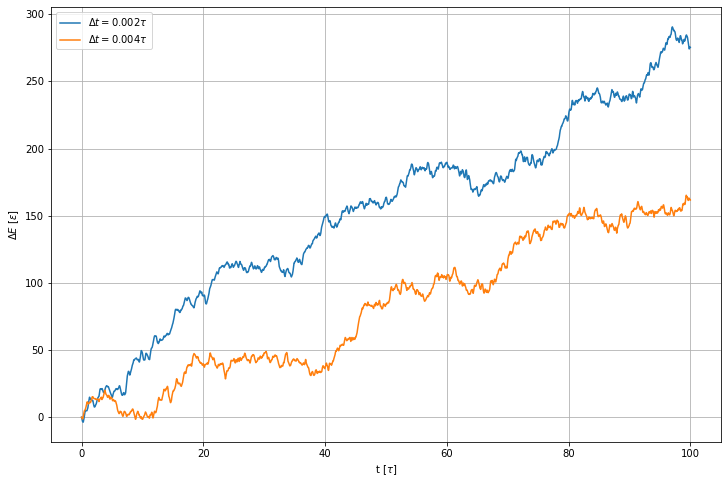

In [47]:
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(t, E-E[0], label=r'$\Delta t=0.002\tau$')
ax1.plot(t_2dt, E_2dt-E_2dt[0], label=r'$\Delta t=0.004\tau$')
ax1.set_xlabel(r't $[\tau]$')
ax1.set_ylabel(r'$\Delta E$ $[\epsilon]$')
ax1.legend()
ax1.grid(True)
plt.savefig('./figures/energy.png', dpi=300, bbox_inches='tight')
plt.show()

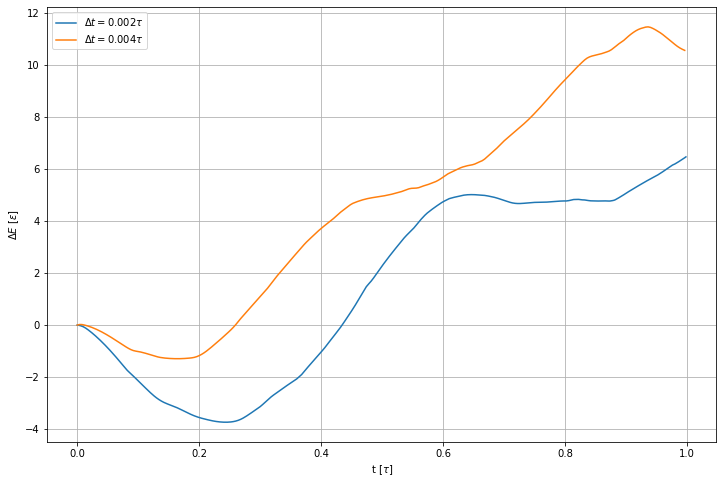

In [48]:
fig2, ax2 = plt.subplots(figsize=(12,8))
ax2.plot(t[np.where(t<1)], E[np.where(t<1)]-E[0], label=r'$\Delta t=0.002\tau$')
ax2.plot(t_2dt[np.where(t_2dt<1)], E_2dt[np.where(t_2dt<1)]-E_2dt[0], label=r'$\Delta t=0.004\tau$')
ax2.set_xlabel(r't $[\tau]$')
ax2.set_ylabel(r'$\Delta E$ $[\epsilon]$')
ax2.legend()
ax2.grid(True)
plt.savefig('./figures/energy_ini.png', dpi=300, bbox_inches='tight')
plt.show()